In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.cm as cm
import plotPRS
import numpy as np
import os,re, pyart, pickle, lzma
import template
import matplotlib.ticker as ticker


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
ZH_Ticks = [-30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 90]
ZDR_Ticks = np.arange(-4, 9, 1)
KDP_Ticks = np.arange(-2, 8, 1)
RHO_Ticks = [0.20, 0.45, 0.65, 0.75, 0.85, 0.9, 0.95, 1]

ref_norm, ref_cmap, zdr_norm, zdr_cmap, kdp_norm, kdp_cmap, rho_norm, rho_cmap, vel_norm, vel_cmap, shear_norm, shear_cmap, w_norm, w_cmap = template.get_ctables()

S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_ideal_1024.xz


/tmp/ipykernel_20380/4036798102.py:79: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)
/tmp/ipykernel_20380/4036798102.py:129: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_20380/4036798102.py:133: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_20380/4036798

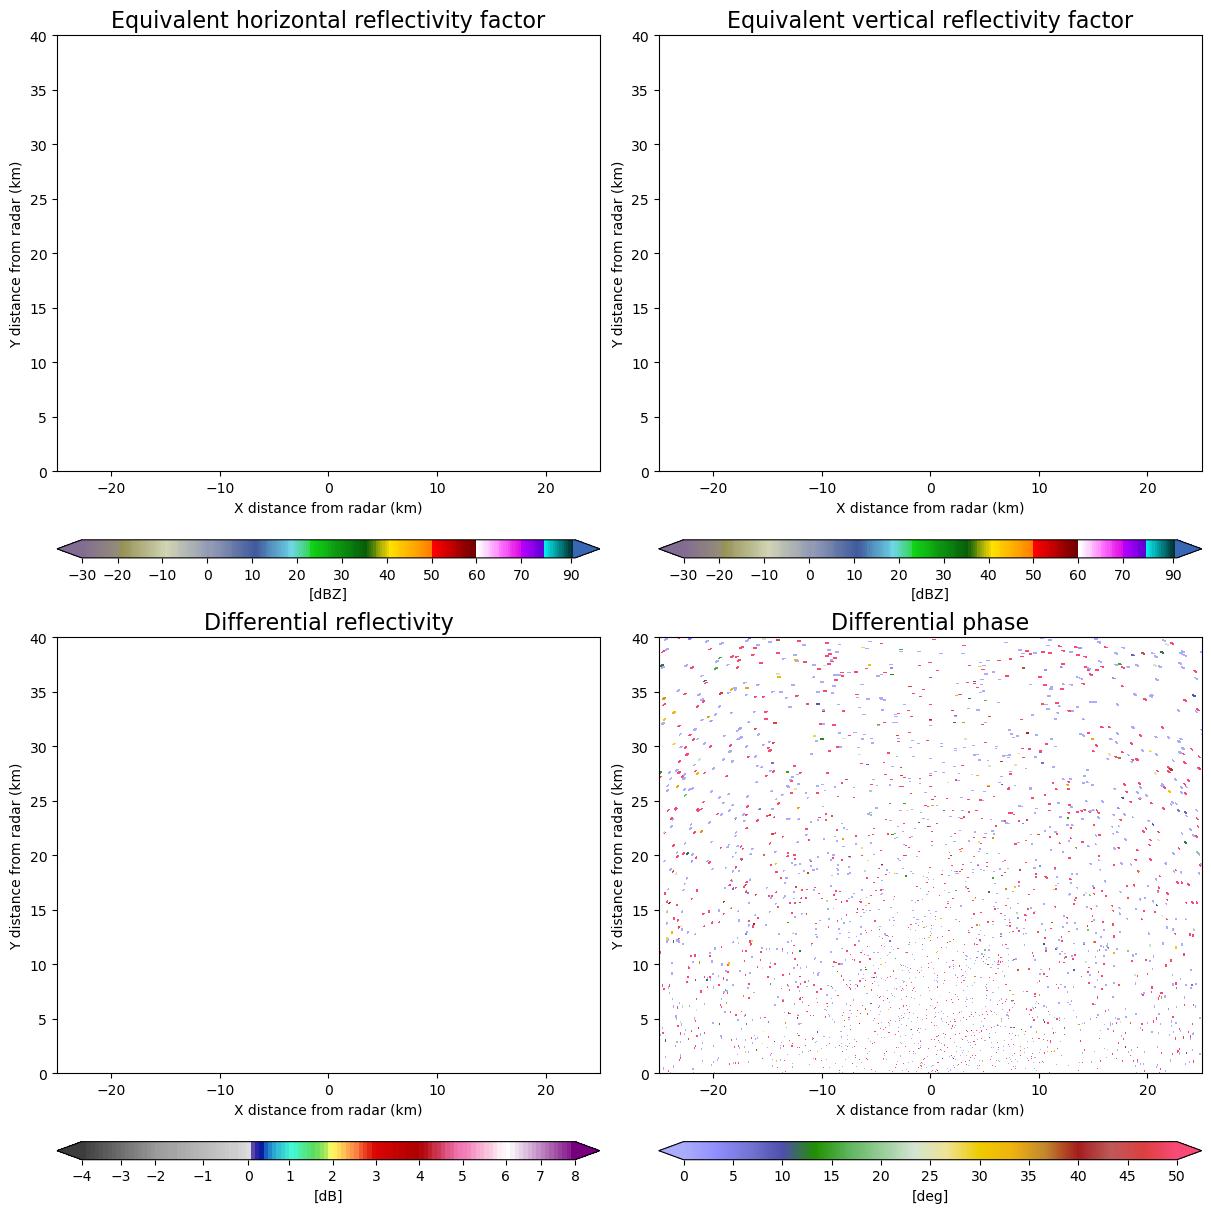

In [6]:
#cc_cmap = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

maes = np.zeros((14,3))
rmses = np.zeros((14,3))
ccs = np.zeros((14,3))
pcts = np.zeros((14,3))
#fp = ''
#os.chdir(fp)
l = np.sort([x for x in os.listdir('.') if re.search('ideal',x)])
#l = l[np.arange(50)!=30]
#l = l[3:4]
# l = np.sort(os.listdir('.'))
#l = l[np.array([7,19,55,80,92])]
#for num,file in enumerate(l): 
file = 'S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_ideal_1024.xz'
print(file)
radarStruct,wxStruct,radars = plotPRS.loadRadars(file)
    
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14



hpp = radars['hpp']
vpp = radars['vpp']
snr = radars['snr']
rr = radars['rr']
df = radars['df']
br = radars['br']
beta = radars['beta']
phi = radars['phi']
vels = []
xx = []
yy = []
zz = []

snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr.append(vpp[i]/N0)
	hpp[i][snr[i] < snrThresh] = np.nan
	vpp[i][snr[i] < snrThresh] = np.nan
	df[i][snr[i] < snrThresh] = np.nan
	vel = np.zeros(df[i].shape)
	xx0 = np.zeros(df[i].shape)
	yy0 = np.zeros(df[i].shape)
	zz0 = np.zeros(df[i].shape)
	inds = np.isnan(df[i])
	df[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr[i]/c,rxPos2[:,i],txPos2)
	    vel[:,el,:] = plotPRS.freq2vel(df[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel[inds] = np.nan
	vels.append(vel)
	xx.append(xx0)
	yy.append(yy0)
	zz.append(zz0)
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1


fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(-25,25)
    ax.set_ylim(0,40)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10((hpp[1][:,0,:])/(vpp[1][:,0,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,phi[1][:,0,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/ideal_1024.png', dpi = 300, bbox_inches = 'tight')
#plt.show()
#plotMoments(x,y,xx,yy,vpp,vels,nRx,figsize)
#plotMultiDop(x,y,xc,yc,xq,yq,zq,uu,vv,ww,uinterp,vinterp,winterp,el,rxPos2,mae)

S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_crap1.xz


/tmp/ipykernel_242758/1182995332.py:77: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)
/tmp/ipykernel_242758/1182995332.py:126: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(hpp1[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/1182995332.py:130: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp1[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/1

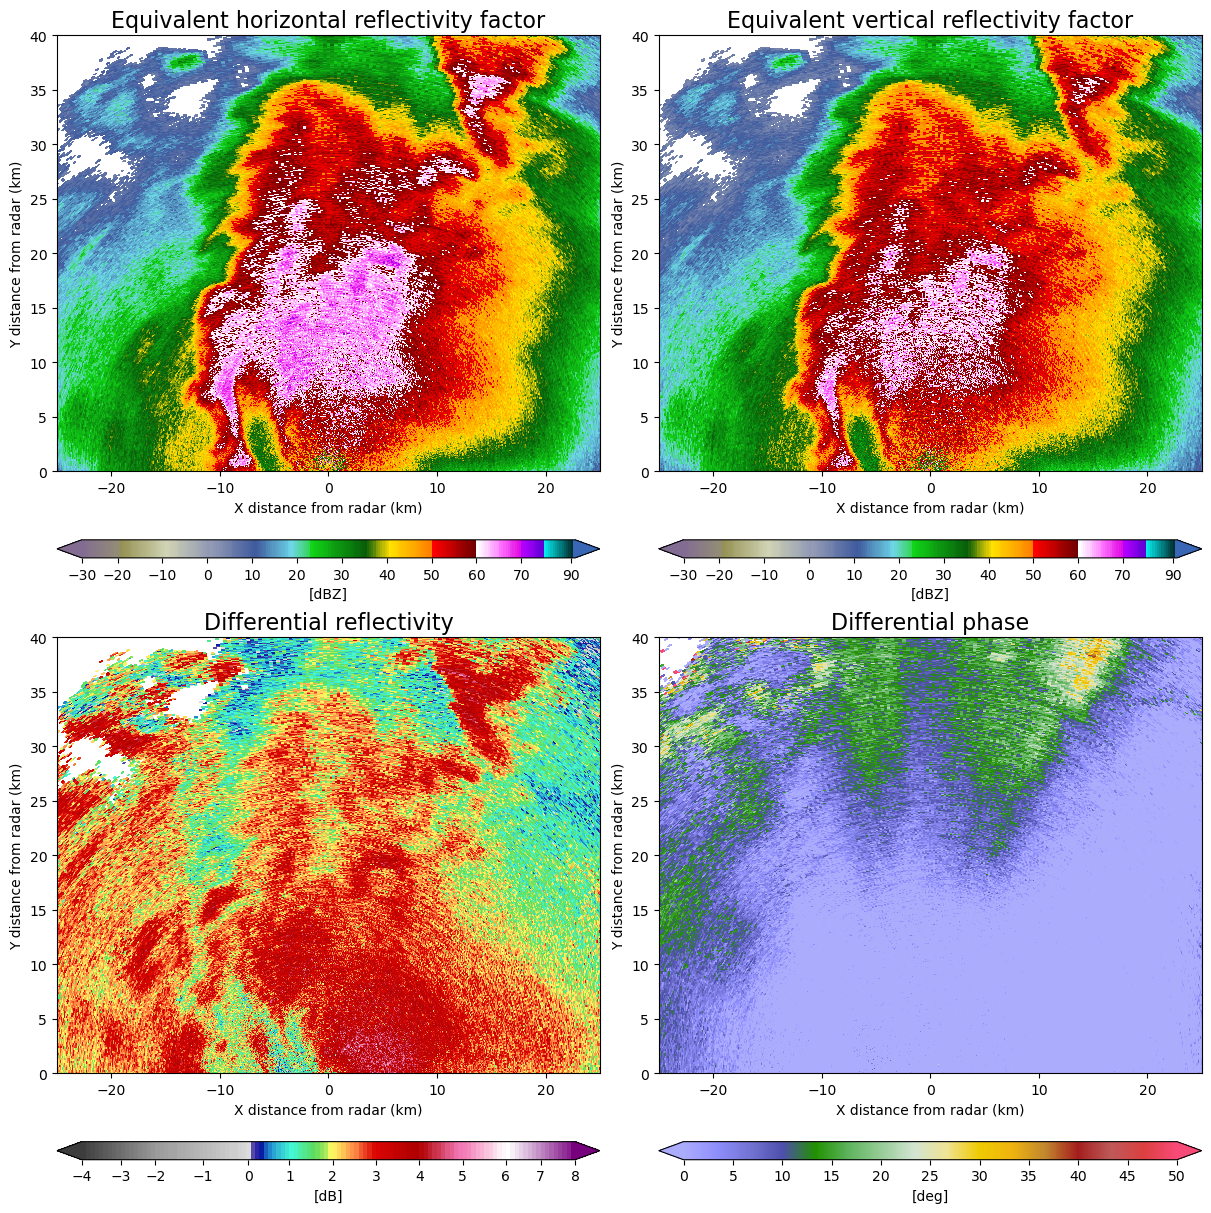

In [19]:
#cc_cmap = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

maes = np.zeros((14,3))
rmses = np.zeros((14,3))
ccs = np.zeros((14,3))
pcts = np.zeros((14,3))
#fp = ''
#os.chdir(fp)
l = np.sort([x for x in os.listdir('.') if re.search('ideal',x)])
#l = l[np.arange(50)!=30]
#l = l[3:4]
# l = np.sort(os.listdir('.'))
#l = l[np.array([7,19,55,80,92])]
#for num,file in enumerate(l): 
file = 'S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_crap1.xz'
print(file)
radarStruct,wxStruct,radars1 = plotPRS.loadRadars(file)
    
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14

hpp1 = radars1['hpp']
vpp1 = radars1['vpp']
snr1 = radars1['snr']
rr1 = radars1['rr']
df1 = radars1['df']
br1 = radars1['br']
beta1 = radars1['beta']
phi1 = radars1['phi']
vels1 = []
xx = []
yy = []
zz = []

snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr1.append(vpp1[i]/N0)
	hpp1[i][snr1[i] < snrThresh] = np.nan
	vpp1[i][snr1[i] < snrThresh] = np.nan
	df1[i][snr1[i] < snrThresh] = np.nan
	vel = np.zeros(df1[i].shape)
	xx0 = np.zeros(df1[i].shape)
	yy0 = np.zeros(df1[i].shape)
	zz0 = np.zeros(df1[i].shape)
	inds = np.isnan(df1[i])
	df1[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr1[i]/c,rxPos2[:,i],txPos2)
	    vel[:,el,:] = plotPRS.freq2vel(df1[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel[inds] = np.nan
	vels1.append(vel)
	xx.append(xx0)
	yy.append(yy0)
	zz.append(zz0)
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1

fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(-25,25)
    ax.set_ylim(0,40)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(hpp1[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp1[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10((hpp1[1][:,0,:])/(vpp1[1][:,0,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,phi1[1][:,0,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/crap.png', dpi = 300, bbox_inches = 'tight')

S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_crap2_1024.xz


/tmp/ipykernel_20380/2808783587.py:77: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)
/tmp/ipykernel_20380/2808783587.py:126: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(hpp2[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_20380/2808783587.py:130: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp2[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_20380/28087

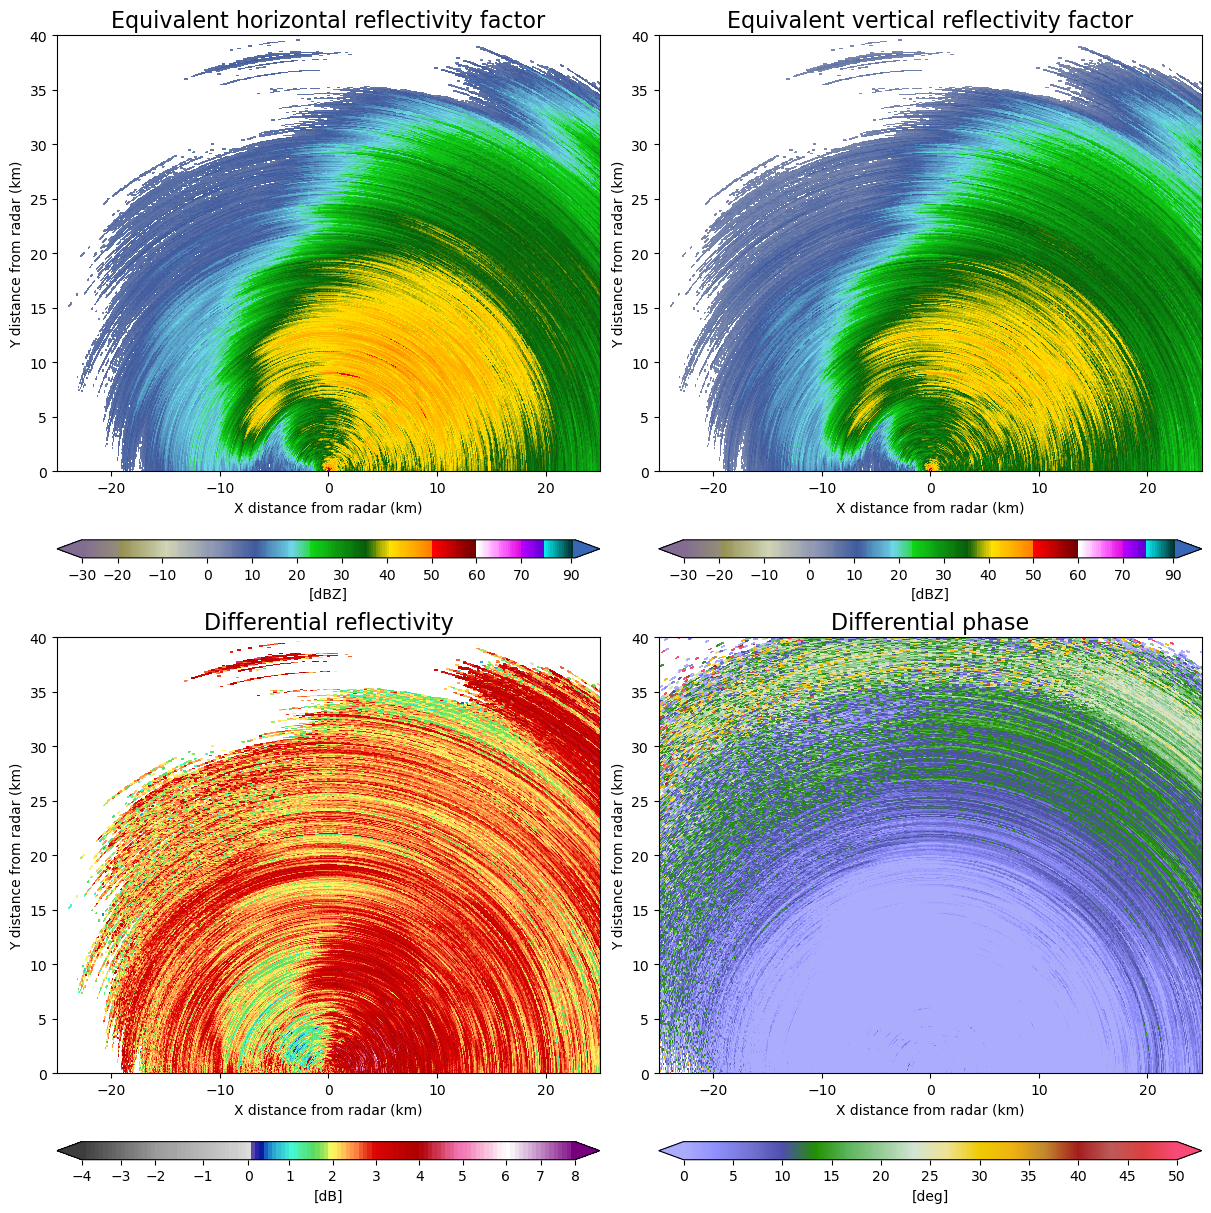

In [5]:
#cc_cmap = colors.LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

maes = np.zeros((14,3))
rmses = np.zeros((14,3))
ccs = np.zeros((14,3))
pcts = np.zeros((14,3))
#fp = ''
#os.chdir(fp)
l = np.sort([x for x in os.listdir('.') if re.search('ideal',x)])
#l = l[np.arange(50)!=30]
#l = l[3:4]
# l = np.sort(os.listdir('.'))
#l = l[np.array([7,19,55,80,92])]
#for num,file in enumerate(l): 
file = 'S_2rx_721az_[0.5]el_16M_100000.0km+unwhitened+A_crap2_1024.xz'
print(file)
radarStruct,wxStruct,radars2 = plotPRS.loadRadars(file)
    
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14

hpp2 = radars2['hpp']
vpp2 = radars2['vpp']
snr2 = radars2['snr']
rr2 = radars2['rr']
df2 = radars2['df']
br2 = radars2['br']
beta2 = radars2['beta']
phi2 = radars2['phi']
vels2 = []
xx = []
yy = []
zz = []

snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr2.append(vpp2[i]/N0)
	hpp2[i][snr2[i] < snrThresh] = np.nan
	vpp2[i][snr2[i] < snrThresh] = np.nan
	df2[i][snr2[i] < snrThresh] = np.nan
	vel = np.zeros(df2[i].shape)
	xx0 = np.zeros(df2[i].shape)
	yy0 = np.zeros(df2[i].shape)
	zz0 = np.zeros(df2[i].shape)
	inds = np.isnan(df2[i])
	df2[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr2[i]/c,rxPos2[:,i],txPos2)
	    vel[:,el,:] = plotPRS.freq2vel(df2[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel[inds] = np.nan
	vels2.append(vel)
	xx.append(xx0)
	yy.append(yy0)
	zz.append(zz0)
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1

fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(-25,25)
    ax.set_ylim(0,40)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(hpp2[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp2[1][:,0,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10((hpp2[1][:,0,:])/(vpp2[1][:,0,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,phi2[1][:,0,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/crap2_1024.png', dpi = 300, bbox_inches = 'tight')

/tmp/ipykernel_242758/4116812426.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3, 10*np.log10(hpp2[1][:,0,:]/hpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
/tmp/ipykernel_242758/4116812426.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp2[1][:,0,:]/vpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
/tmp/ipykernel_242758/4116812426.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers,

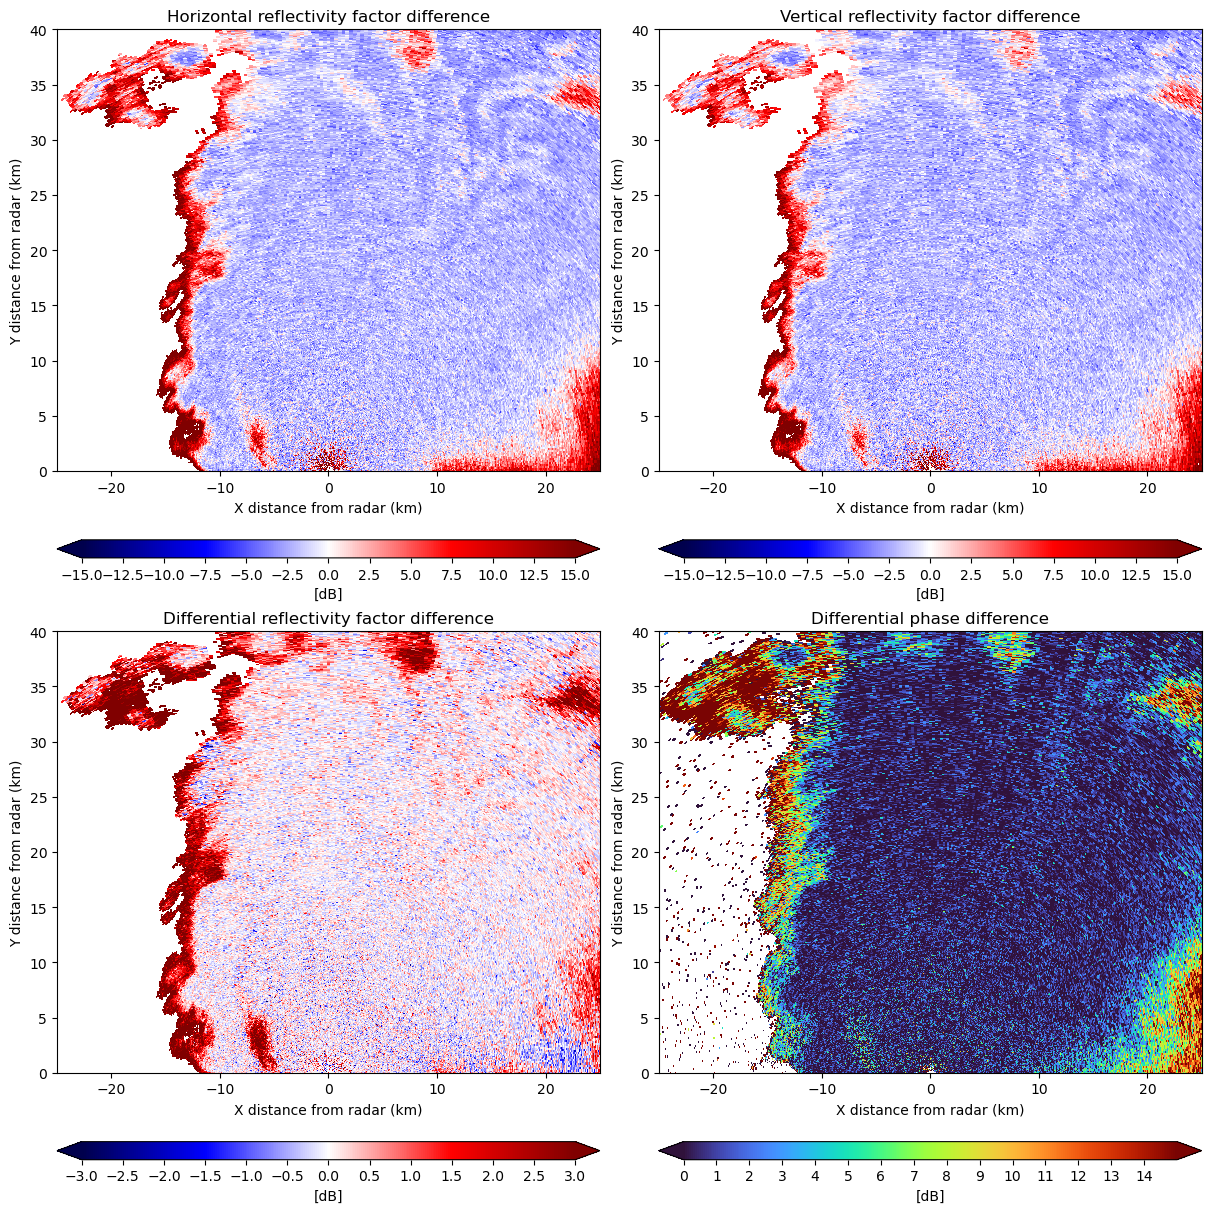

In [33]:
fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Horizontal reflectivity factor difference', 'Vertical reflectivity factor difference', 'Differential reflectivity difference', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(-25,25)
    ax.set_ylim(0,40)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3, 10*np.log10(hpp2[1][:,0,:]/hpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[0].set_title('Horizontal reflectivity factor difference')
cbar0 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[0], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp2[1][:,0,:]/vpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[1].set_title('Vertical reflectivity factor difference')
cbar1 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar1.ax.minorticks_off()

im = axs.ravel()[2].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10((hpp2[1][:,0,:]*vpp[1][:,0,:])/(hpp[1][:,0,:]*vpp2[1][:,0,:])), cmap='seismic', vmin = -2, vmax = 2)
axs.ravel()[2].set_title('Differential reflectivity factor difference')
cbar2 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-3, vmax=3), 'seismic'), ax = axs.ravel()[2], extend = 'both', ticks = np.arange(-3, 3.5, .5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,phi2[1][:,0,:]-phi[1][:,0,:], cmap='turbo', vmin = 0, vmax = 15)
axs.ravel()[3].set_title('Differential phase difference')
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=15), 'turbo'), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 15, 1),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar3.ax.minorticks_off()

#plt.show()
#plotMoments(x,y,xx,yy,vpp,vels,nRx,figsize)
#plotMultiDop(x,y,xc,yc,xq,yq,zq,uu,vv,ww,uinterp,vinterp,winterp,el,rxPos2,mae)

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/aa2.png', bbox_inches = 'tight')

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Horizontal reflectivity factor difference', 'Vertical reflectivity factor difference', 'Differential reflectivity difference', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(-25,25)
    ax.set_ylim(0,40)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3, 10*np.log10(hpp1[1][:,0,:]/hpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[0].set_title('Horizontal reflectivity factor difference')
cbar0 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[0], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10(vpp1[1][:,0,:]/vpp[1][:,0,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[1].set_title('Vertical reflectivity factor difference')
cbar1 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar1.ax.minorticks_off()

im = axs.ravel()[2].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,10*np.log10((hpp1[1][:,0,:]*vpp[1][:,0,:])/(hpp[1][:,0,:]*vpp1[1][:,0,:])), cmap='seismic', vmin = -2, vmax = 2)
axs.ravel()[2].set_title('Differential reflectivity factor difference')
cbar2 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-3, vmax=3), 'seismic'), ax = axs.ravel()[2], extend = 'both', ticks = np.arange(-3, 3.5, .5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,phi1[1][:,0,:]-phi[1][:,0,:], cmap='turbo', vmin = 0, vmax = 15)
axs.ravel()[3].set_title('Differential phase difference')
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=15), 'turbo'), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 15, 1),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar3.ax.minorticks_off()

#plt.show()
#plotMoments(x,y,xx,yy,vpp,vels,nRx,figsize)
#plotMultiDop(x,y,xc,yc,xq,yq,zq,uu,vv,ww,uinterp,vinterp,winterp,el,rxPos2,mae)

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/aa.png', bbox_inches = 'tight')

In [37]:
file = 'S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_ideal.xz'
print(file)
radarStruct,wxStruct,radars = plotPRS.loadRadars(file)

S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_ideal.xz


In [38]:
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14

hpp = radars['hpp']
vpp = radars['vpp']
snr = radars['snr']
rr = radars['rr']
df = radars['df']
br = radars['br']
beta = radars['beta']
phi = radars['phi']
vels = []
xx = []
yy = []
zz = []

In [39]:
snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr.append(vpp[i]/N0)
	hpp[i][snr[i] < snrThresh] = np.nan
	vpp[i][snr[i] < snrThresh] = np.nan
	df[i][snr[i] < snrThresh] = np.nan
	vel = np.zeros(df[i].shape)
	xx0 = np.zeros(df[i].shape)
	yy0 = np.zeros(df[i].shape)
	zz0 = np.zeros(df[i].shape)
	inds = np.isnan(df[i])
	df[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr[i]/c,rxPos2[:,i],txPos2)
	    vel[:,el,:] = plotPRS.freq2vel(df[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel[inds] = np.nan
	vels.append(vel)
	xx.append(xx0)
	yy.append(yy0)
	zz.append(zz0)

/tmp/ipykernel_242758/3559236041.py:6: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)


/tmp/ipykernel_242758/3134436765.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(hpp[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/3134436765.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/3134436765.py:35: UserWarning: The input coordinates to pcolormesh a

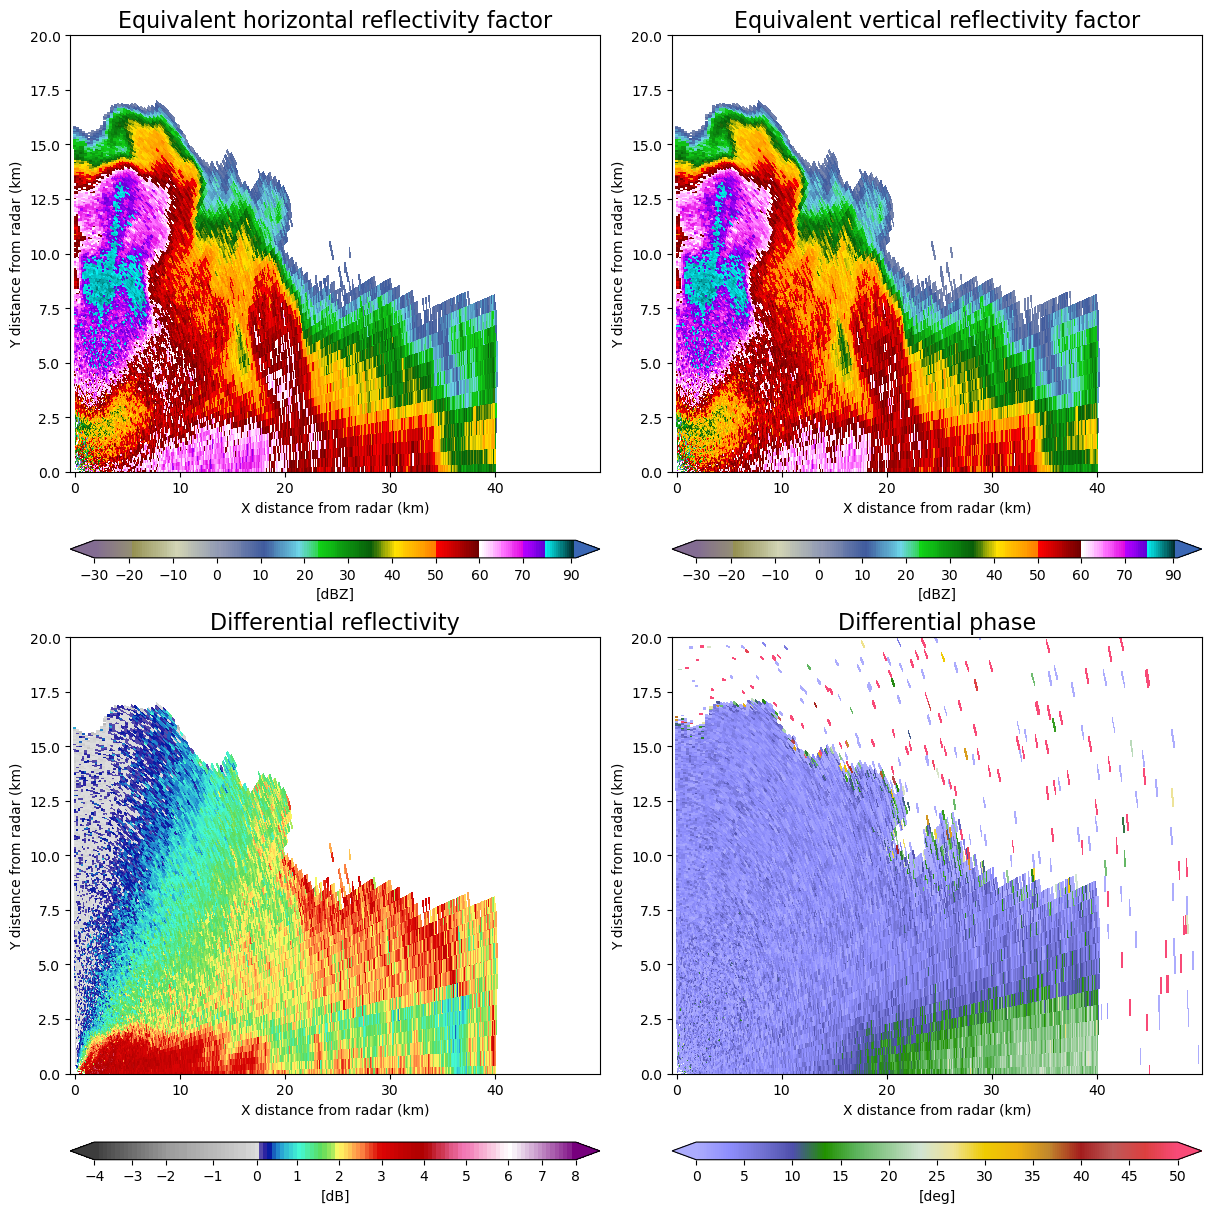

In [10]:
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1

fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    #ax.set_xlim(-25,25)
    ax.set_ylim(0,20)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(hpp[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10((hpp[1][0,:,:])/(vpp[1][0,:,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,phi[1][0,:,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/ideal_rhi.png', dpi = 300, bbox_inches = 'tight')

In [11]:
file = 'S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_crap1.xz'
print(file)
radarStruct,wxStruct,radars1 = plotPRS.loadRadars(file)

S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_crap1.xz


In [12]:
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14

hpp1 = radars1['hpp']
vpp1 = radars1['vpp']
snr1 = radars1['snr']
rr1 = radars1['rr']
df1 = radars1['df']
br1 = radars1['br']
beta1 = radars1['beta']
phi1 = radars1['phi']
vels1 = []
xx1 = []
yy1 = []
zz1 = []

In [13]:
snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr1.append(vpp1[i]/N0)
	hpp1[i][snr1[i] < snrThresh] = np.nan
	vpp1[i][snr1[i] < snrThresh] = np.nan
	df1[i][snr1[i] < snrThresh] = np.nan
	vel1 = np.zeros(df1[i].shape)
	xx0 = np.zeros(df1[i].shape)
	yy0 = np.zeros(df1[i].shape)
	zz0 = np.zeros(df1[i].shape)
	inds = np.isnan(df1[i])
	df1[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr1[i]/c,rxPos2[:,i],txPos2)
	    vel1[:,el,:] = plotPRS.freq2vel(df1[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel1[inds] = np.nan
	vels1.append(vel1)
	xx1.append(xx0)
	yy1.append(yy0)
	zz1.append(zz0)

/tmp/ipykernel_242758/701550668.py:6: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)


/tmp/ipykernel_242758/871286643.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,10*np.log10(hpp1[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/871286643.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,10*np.log10(vpp1[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/871286643.py:35: UserWarning: The input coordinates to pcolorm

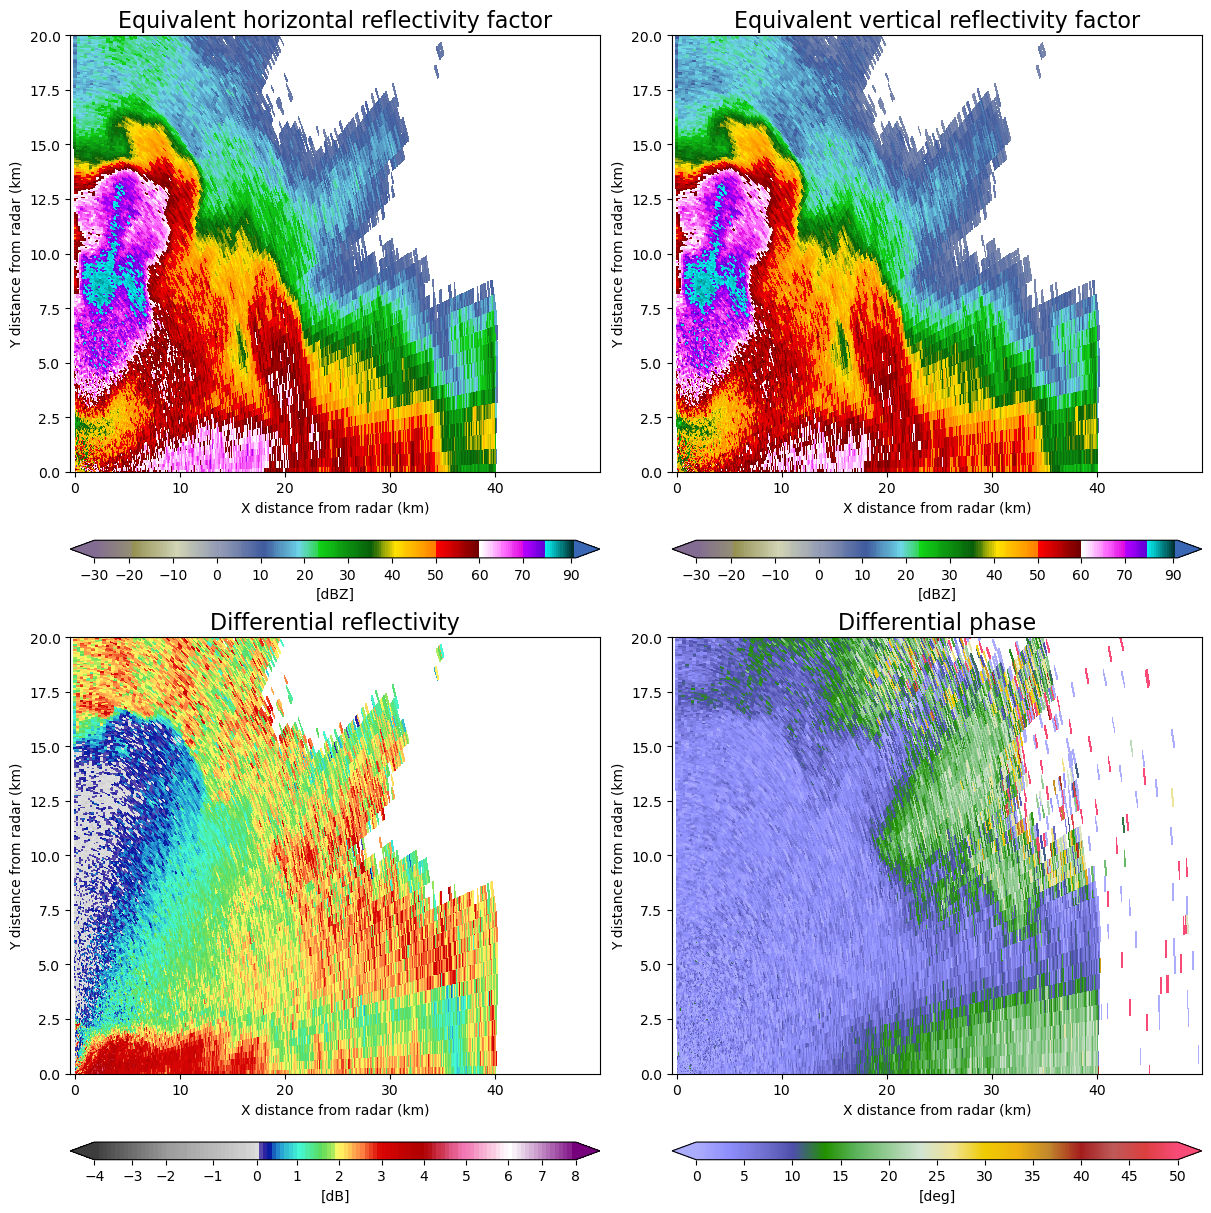

In [14]:
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1

fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    #ax.set_xlim(-25,25)
    ax.set_ylim(0,20)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,10*np.log10(hpp1[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,10*np.log10(vpp1[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,10*np.log10((hpp1[1][0,:,:])/(vpp1[1][0,:,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(np.sqrt((xx1[1][0,:,:]/1e3)**2+(yy1[1][0,:,:]/1e3)**2),zz1[1][0,:,:]/1e3,phi1[1][0,:,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/rhi_crap.png', dpi = 300, bbox_inches = 'tight')

/tmp/ipykernel_242758/2075913289.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3, 10*np.log10(hpp1[1][0,:,:]/hpp[1][0,:,:]), cmap='seismic', vmin = -15, vmax = 15)
/tmp/ipykernel_242758/2075913289.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp1[1][0,:,:]/vpp[1][0,:,:]), cmap='seismic', vmin = -15, vmax = 15)
/tmp/ipykernel_242758/2075913289.py:22: UserWarni

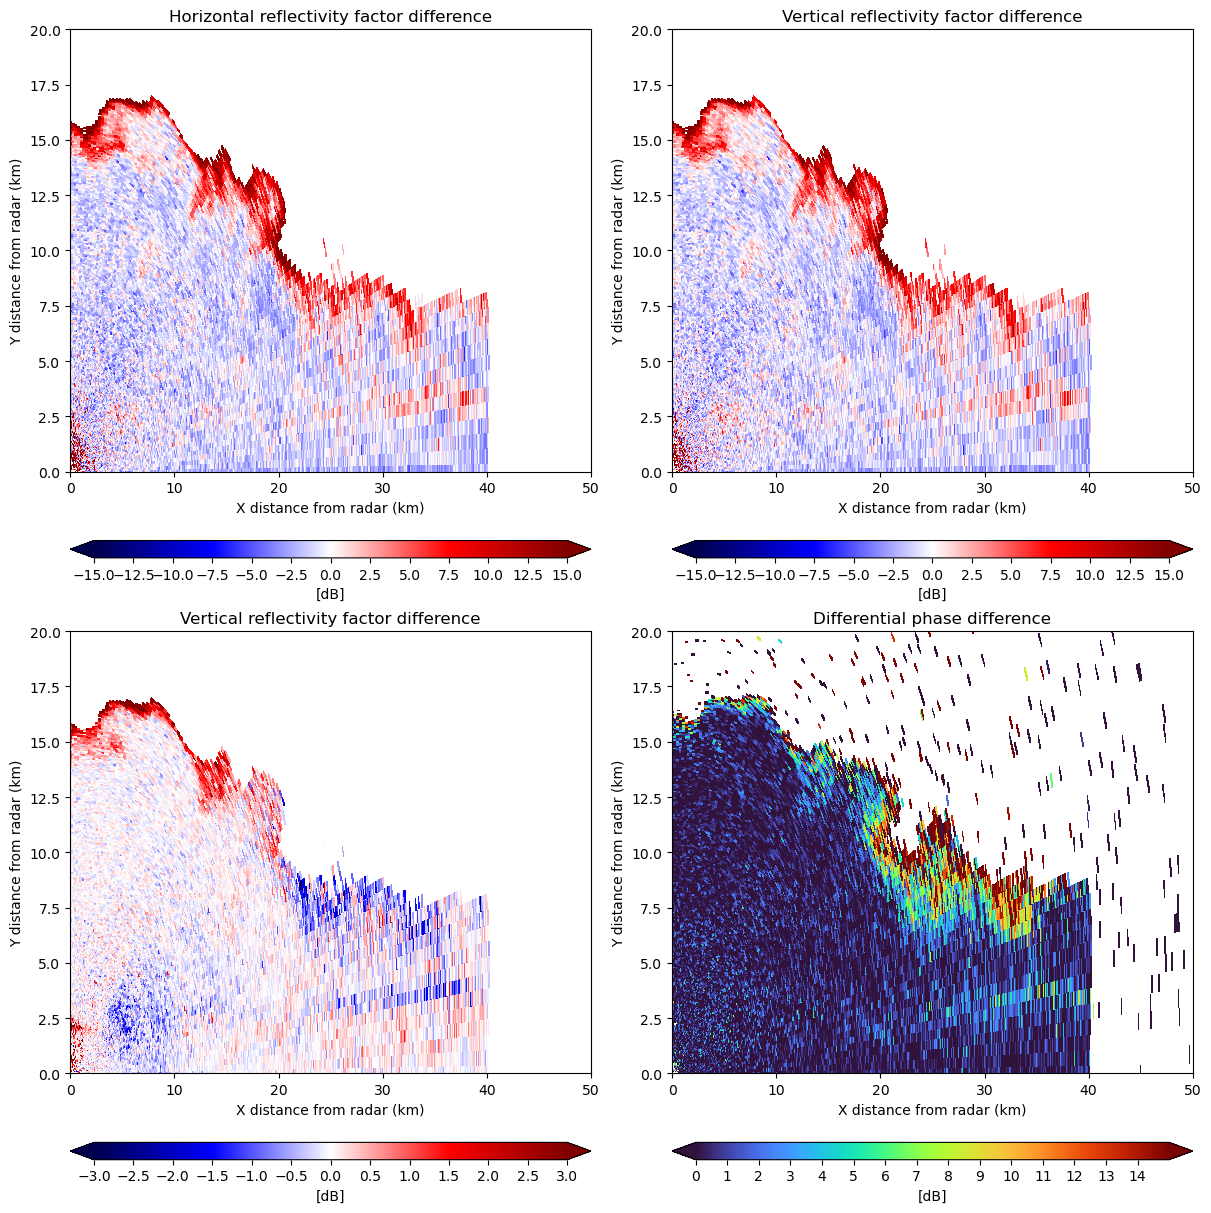

In [16]:
fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Horizontal reflectivity factor difference', 'Vertical reflectivity factor difference', 'Differential reflectivity difference', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(0,50)
    ax.set_ylim(0,20)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3, 10*np.log10(hpp1[1][0,:,:]/hpp[1][0,:,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[0].set_title('Horizontal reflectivity factor difference')
cbar0 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[0], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp1[1][0,:,:]/vpp[1][0,:,:]), cmap='seismic', vmin = -15, vmax = 15)
axs.ravel()[1].set_title('Vertical reflectivity factor difference')
cbar1 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar1.ax.minorticks_off()

im = axs.ravel()[2].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10((hpp1[1][0,:,:]*vpp[1][0,:,:])/(hpp[1][0,:,:]*vpp1[1][0,:,:])),
                               cmap='seismic', vmin = -2, vmax = 2)
axs.ravel()[2].set_title('Vertical reflectivity factor difference')
cbar2 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-3, vmax=3), 'seismic'), ax = axs.ravel()[2], extend = 'both', ticks = np.arange(-3, 3.5, .5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,phi1[1][0,:,:]-phi[1][0,:,:], cmap='turbo', vmin = 0, vmax = 15)
axs.ravel()[3].set_title('Differential phase difference')
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=15), 'turbo'), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 15, 1),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar3.ax.minorticks_off()

#plt.show()
#plotMoments(x,y,xx,yy,vpp,vels,nRx,figsize)
#plotMultiDop(x,y,xc,yc,xq,yq,zq,uu,vv,ww,uinterp,vinterp,winterp,el,rxPos2,mae)

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/aa_rhi.png', bbox_inches = 'tight')

In [34]:
file = 'S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_crap2.xz'
print(file)
radarStruct,wxStruct,radars2 = plotPRS.loadRadars(file)

S_2rx_2az_0.0-90.0el_16M_unwhitened_10000.0km+unwhitened+A_crap2.xz


In [35]:
txPos = radarStruct['txPos']
rxPos = radarStruct['rxPos']
_lambda = radarStruct['lambda']
prt = radarStruct['prt']
tau = radarStruct['tau']
fs = radarStruct['fs'] 
Pt = radarStruct['Pt'] 
Tant = radarStruct['Tant'] 
Frx = radarStruct['Frx'] 
M = radarStruct['M'] 
txAz = radarStruct['txAz'] 
txEl = radarStruct['txEl'] 
rxMechTilt = radarStruct['rxMechTilt'] 
txMechEl = radarStruct['txMechEl'] 
txG = radarStruct['txG']
rxG = radarStruct['rxG'] 

scatMode = wxStruct['scatMode'] 
xSize = wxStruct['xSize'] 
ySize = wxStruct['ySize']
zSize = wxStruct['zSize']
wrfDate = wxStruct['wrfDate'] 
wrfOffset = wxStruct['wrfOffset']
# idealPat = radarStruct['idealPat']
# whitening = radarStruct['whitening']
# dishMode = radarStruct['dishMode']
# tmMode = radarStruct['tmMode']
# saveMode = radarStruct['saveMode']

c = 3e8 
nRx = rxPos.shape[0]
nEl = txMechEl.shape[0]
Ts = 1/fs 
T0 = 290
Trec = T0*(10**(Frx/10)-1) 
B = fs 
k = 1.381e-23 
N0 = k*(Tant+Trec)*B 
cn = 1e-14

hpp2 = radars2['hpp']
vpp2 = radars2['vpp']
snr2 = radars2['snr']
rr2 = radars2['rr']
df2 = radars2['df']
br2 = radars2['br']
beta2 = radars2['beta']
phi2 = radars2['phi']
vels2 = []
xx2 = []
yy2 = []
zz2 = []

In [36]:
snrThresh = 10**(12/10)
brThresh = 1e3

txrxDist = np.sqrt(np.sum((txPos-rxPos)**2,axis=1))
rxPhi = np.arctan2(rxPos[:,1]-txPos[1],rxPos[:,0]-txPos[0])
rxTheta = np.arccos(rxPos[:,2]/txrxDist)
rxTheta[-1] = 0
rxPos2 = np.array([np.cos(rxPhi)*np.sin(rxTheta), np.sin(rxPhi)*np.sin(rxTheta),np.cos(rxTheta)])*txrxDist
txPos2 = np.zeros(3)
for i in range(nRx):
	snr2.append(vpp2[i]/N0)
	hpp2[i][snr2[i] < snrThresh] = np.nan
	vpp2[i][snr2[i] < snrThresh] = np.nan
	df2[i][snr2[i] < snrThresh] = np.nan
	vel2 = np.zeros(df2[i].shape)
	xx0 = np.zeros(df2[i].shape)
	yy0 = np.zeros(df2[i].shape)
	zz0 = np.zeros(df2[i].shape)
	inds = np.isnan(df2[i])
	df2[i][inds] = 0
	for el in range(nEl):
	    pts = plotPRS.localize(90-txAz,radarStruct['txMechEl'][el]*np.ones(txAz.shape),rr2[i]/c,rxPos2[:,i],txPos2)
	    vel2[:,el,:] = plotPRS.freq2vel(df2[i][:,el,:],pts[:,:,0],pts[:,:,1],pts[:,:,2],rxPos2[:,i],txPos2,_lambda)
	    xx0[:,el,:] = pts[:,:,0]
	    yy0[:,el,:] = pts[:,:,1]
	    zz0[:,el,:] = pts[:,:,2]
	vel2[inds] = np.nan
	vels2.append(vel2)
	xx2.append(xx0)
	yy2.append(yy0)
	zz2.append(zz0)

/tmp/ipykernel_242758/3891357681.py:6: RuntimeWarning: invalid value encountered in divide
  rxTheta = np.arccos(rxPos[:,2]/txrxDist)


/tmp/ipykernel_242758/1867115774.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,10*np.log10(hpp2[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/1867115774.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,10*np.log10(vpp2[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
/tmp/ipykernel_242758/1867115774.py:35: UserWarning: The input coordinates to pcol

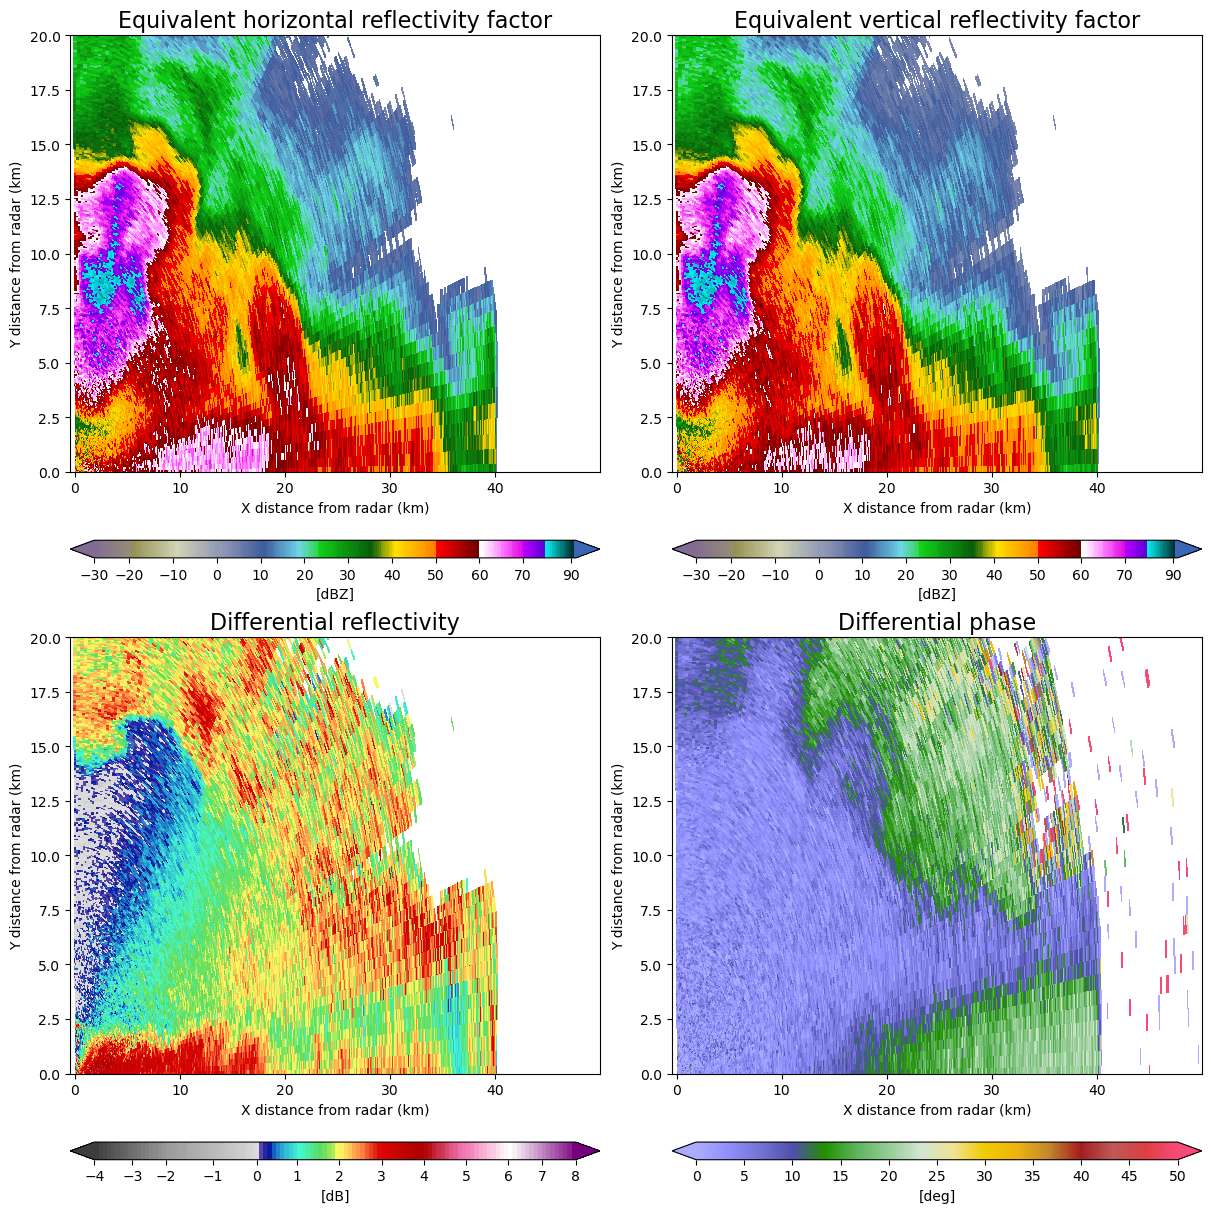

In [28]:
el = 0
figsize = (14,8)

rxc = 0e3
ryc = 0e3
rwindow = 15*1e3

xc = 0
yc = 0
window = 25
x = (xc-window, xc+window)
y = (yc-window, yc+window)
s = 1

fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Equivalent horizontal reflectivity factor', 'Equivalent vertical reflectivity factor', 'Differential reflectivity', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    #ax.set_xlim(-25,25)
    ax.set_ylim(0,20)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,10*np.log10(hpp2[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar0 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[0], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar0.ax.minorticks_off()

im = axs.ravel()[1].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,10*np.log10(vpp2[1][0,:,:]) + 45,cmap=ref_cmap, norm=ref_norm)
cbar1 = fig.colorbar(cm.ScalarMappable(ref_norm, ref_cmap), ax = axs.ravel()[1], extend = 'both', ticks = ZH_Ticks, orientation = 'horizontal', aspect = 30, label = '[dBZ]', pad = 0.05)
cbar1.ax.minorticks_off()
#im = axs.ravel()[1].pcolormesh(xx[1][:,0,:]/1e3,yy[1][:,0,:]/1e3,vel[:,0,:],cmap=vel_cmap, norm=vel_norm)
#fig.colorbar(cm.ScalarMappable(vel_norm, vel_cmap), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-50, 60, 10), orientation = 'horizontal', aspect = 30,
#                 shrink = 0.85, label = '[m/s]', pad = 0.05)

im = axs.ravel()[2].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,10*np.log10((hpp2[1][0,:,:])/(vpp2[1][0,:,:])),cmap=zdr_cmap,norm=zdr_norm)
cbar2 = fig.colorbar(cm.ScalarMappable(zdr_norm, zdr_cmap), ax = axs.ravel()[2], extend = 'both', ticks = ZDR_Ticks,
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(np.sqrt((xx2[1][0,:,:]/1e3)**2+(yy2[1][0,:,:]/1e3)**2),zz2[1][0,:,:]/1e3,phi2[1][0,:,:],cmap=pyart.graph.cm.Theodore16, norm = mplcolors.Normalize(vmin=0, vmax=50))
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=50), pyart.graph.cm.Theodore16), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 55, 5),
                 orientation = 'horizontal', aspect = 30, label = '[deg]', pad = 0.05)
cbar3.ax.minorticks_off()

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/rhi_crap2.png', dpi = 300, bbox_inches = 'tight')

/tmp/ipykernel_242758/296873417.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3, 10*np.log10(hpp2[1][0,:,:]/hpp[1][0,:,:]), cmap='seismic', vmin = -20, vmax = 20)
/tmp/ipykernel_242758/296873417.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp2[1][0,:,:]/vpp[1][0,:,:]), cmap='seismic', vmin = - 20, vmax = 20)
/tmp/ipykernel_242758/296873417.py:24: UserWarning

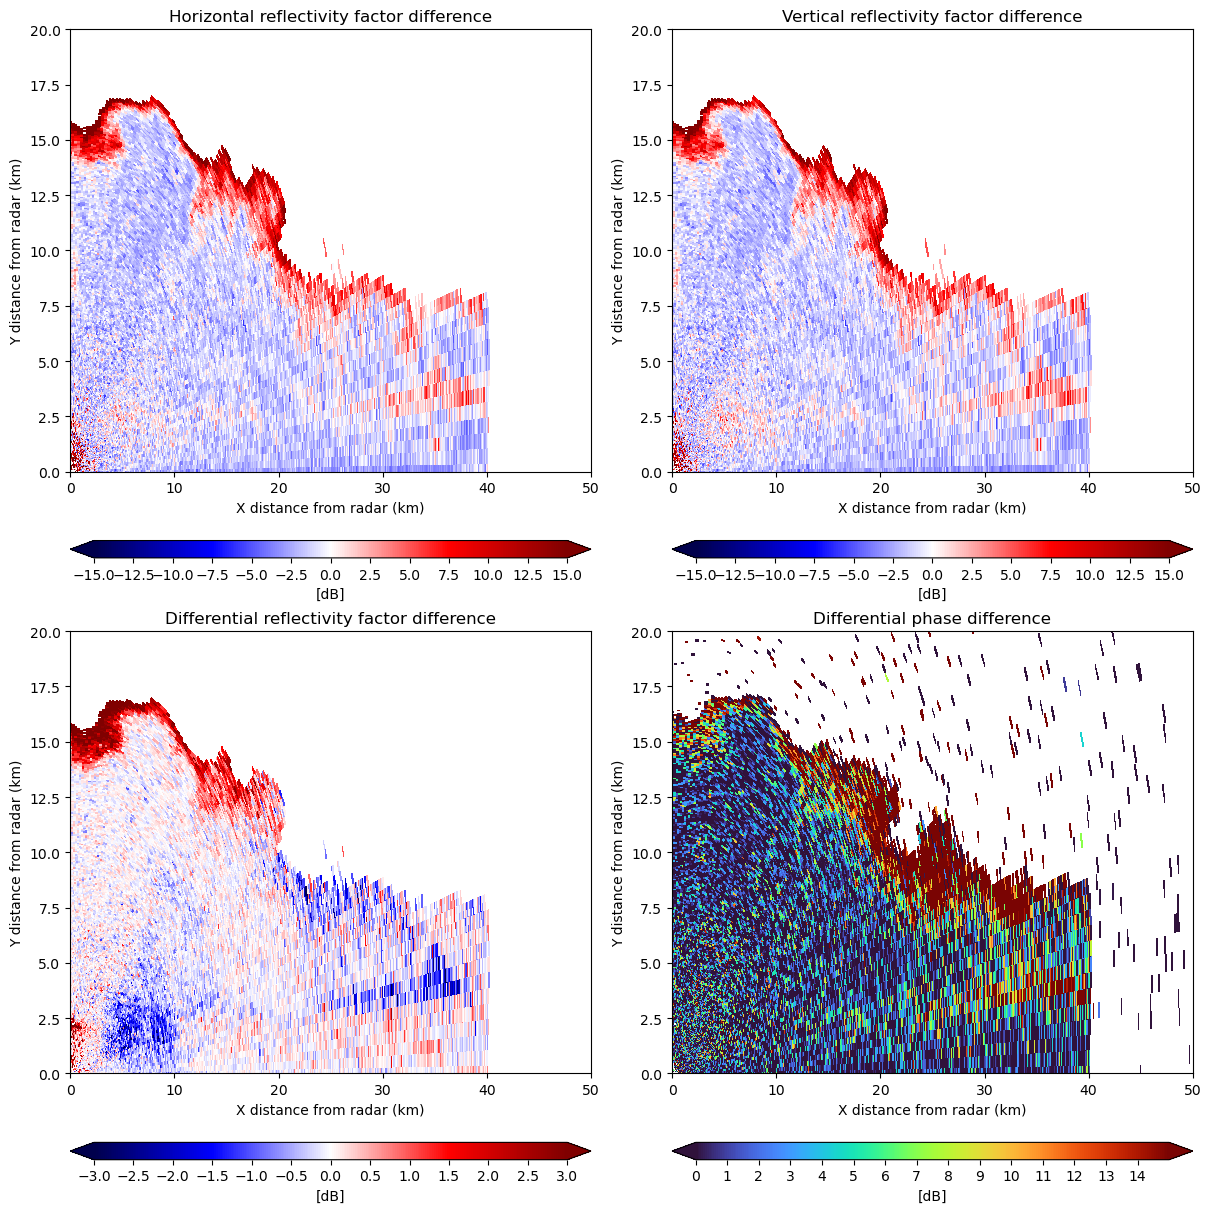

In [42]:
fig,axs = plt.subplots(2,2,figsize=(12,12), constrained_layout = True)

for ax, title in zip(axs.ravel(),['Horizontal reflectivity factor difference', 'Vertical reflectivity factor difference', 'Differential reflectivity difference', 'Differential phase']):
    ax.set_title(title, fontsize = 16)
    ax.set_xlim(0,50)
    ax.set_ylim(0,20)
    ax.set_xlabel('X distance from radar (km)')
    ax.set_ylabel('Y distance from radar (km)')

im = axs.ravel()[0].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3, 10*np.log10(hpp2[1][0,:,:]/hpp[1][0,:,:]), cmap='seismic', vmin = -20, vmax = 20)
axs.ravel()[0].set_title('Horizontal reflectivity factor difference')
cbar0 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[0], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar0.ax.minorticks_off()


im = axs.ravel()[1].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10(vpp2[1][0,:,:]/vpp[1][0,:,:]), cmap='seismic', vmin = - 20, vmax = 20)
axs.ravel()[1].set_title('Vertical reflectivity factor difference')
cbar1 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-15, vmax=15), 'seismic'), ax = axs.ravel()[1], extend = 'both', ticks = np.arange(-15, 17.5, 2.5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar1.ax.minorticks_off()


im = axs.ravel()[2].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,10*np.log10((hpp2[1][0,:,:]*vpp[1][0,:,:])/(hpp[1][0,:,:]*vpp2[1][0,:,:])),
                               cmap='seismic', vmin = -2, vmax = 2)
axs.ravel()[2].set_title('Differential reflectivity factor difference')
cbar2 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=-3, vmax=3), 'seismic'), ax = axs.ravel()[2], extend = 'both', ticks = np.arange(-3, 3.5, .5),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar2.ax.minorticks_off()

im = axs.ravel()[3].pcolormesh(np.sqrt((xx[1][0,:,:]/1e3)**2+(yy[1][0,:,:]/1e3)**2),zz[1][0,:,:]/1e3,phi2[1][0,:,:]-phi[1][0,:,:], cmap='turbo', vmin = 0, vmax = 5)
axs.ravel()[3].set_title('Differential phase difference')
cbar3 = fig.colorbar(cm.ScalarMappable(mplcolors.Normalize(vmin=0, vmax=15), 'turbo'), ax = axs.ravel()[3], extend = 'both', ticks = np.arange(0, 15, 1),
                 orientation = 'horizontal', aspect = 30, label = '[dB]', pad = 0.05)
cbar3.ax.minorticks_off()

#plt.show()
#plotMoments(x,y,xx,yy,vpp,vels,nRx,figsize)
#plotMultiDop(x,y,xc,yc,xq,yq,zq,uu,vv,ww,uinterp,vinterp,winterp,el,rxPos2,mae)

plt.savefig('/mnt/c/Users/goed0002/OneDrive - University of Oklahoma/Desktop/aa_rhi2.png', bbox_inches = 'tight')